In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy import stats
import networkx as nx

%matplotlib inline

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def create_bar_plot(data, x_title, y_title):
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    ax.hist(x=data, bins='auto', alpha=0.7, rwidth=0.85)
    ax.grid(False)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_xscale("log")
    #ax.set_xlim(1, 1000)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    plt.show()
    return fig

In [4]:
def load_ontology(file_name):
    dG = nx.DiGraph()
    file_handle = open(file_name)
    for line in file_handle:
        line = line.rstrip().split()
        if line[2] == 'default':
            dG.add_edge(line[0], line[1])
    file_handle.close()    
    return dG

In [5]:
def get_next_layer(dg, stack, term_visited):
    new_stack = []
    count = 0
    while len(stack) > 0:
        term = stack.pop()
        count += 1
        if term in term_visited:
            continue
        term_visited[term] = 1
        for n in list(dg.neighbors(term)):
            new_stack.append(n)
    return new_stack, count

In [6]:
def get_cell_lines_by_tissue_type(tissue_type, cell_annot_df, cell_lines_df):
    ccle_tissue_cell_lines = list(cell_annot_df.query('Site_Primary == @tissue_type')['CCLE_ID'])
    return cell_lines_df.query('C in @ccle_tissue_cell_lines')

In [7]:
train_df = pd.read_csv('../data/drugcell_all.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
drugs = pd.read_csv('../data/drug2ind.txt', sep='\t', header=None, names=['I', 'D'])['D']
cell_lines_df = pd.read_csv('../data/cell2ind.txt', sep='\t', header=None, names=['I', 'C'])

ontology_file = '../data/NeST_clinical_trial_ont.txt'
cell_mutation = np.loadtxt('../data/cell2mutation_clinical_trial.txt', delimiter=',')
genes = set(pd.read_csv('../data/gene2ind_clinical_trial.txt', sep='\t', header=None, names=['I', 'G'])['G'])

genes_orig = set(pd.read_csv('../../drugcell/data/gene2ind.txt', sep='\t', header=None, names=['I', 'G'])['G'])
cells_orig = set(pd.read_csv('../../drugcell/data/cell2ind.txt', sep='\t', header=None, names=['I', 'C'])['C'])
cell_mutation_orig = np.loadtxt('../../drugcell/data/cell2mutation.txt', delimiter=',')

cell_types_df = pd.read_csv('../data/CCLE/ccle_maf.txt', sep='\t')
cell_annot_df = pd.read_csv('../data/CCLE/cell_line_annotations.txt', sep="\t")

nest_gene_list = []
with open('../data/gene_list_NeST.txt', 'r') as file:
    nest_gene_list = file.read().split()
    
onco_kb_data = pd.read_csv('../data/ONCO_KB/oncokb.tsv', sep='\t')
onco_kb_genes = set(onco_kb_data['Gene'])

genie_genes = set(pd.read_csv('../data/GENIE/Mutated_Genes.txt', sep='\t')['Gene'])

In [ ]:
# No. of mutations in cell-lines

mutation_count = np.count_nonzero(cell_mutation == 1, axis=1)
print('Median per cell line:', np.median(mutation_count))
print('Mean per cell line:', np.mean(mutation_count))

fig = create_bar_plot(mutation_count, 'Number of mutations', 'Number of cell lines')
#fig.savefig('../plots/Reactome_small_mutation_count.png')

In [ ]:
tissue = 'breast'
tissue_cl_df = get_cell_lines_by_tissue_type(tissue, cell_annot_df, cell_lines_df)
tissue_cl_indices = list(tissue_cl_df['I'])
tissue_cell_mutation = cell_mutation[tissue_cl_indices, :]
mutation_count = np.count_nonzero(tissue_cell_mutation == 1, axis=1)

print('Median per cell line:', np.median(mutation_count))
print('Mean per cell line:', np.mean(mutation_count))

fig = create_bar_plot(mutation_count, 'Number of mutations', 'Number of cell lines')

In [ ]:
mut_count_per_gene = cell_mutation.transpose()
mutation_count_g = np.count_nonzero(mut_count_per_gene == 1, axis=1)
print('Median per gene:', np.median(mutation_count_g))
print('Mean per gene:', np.mean(mutation_count_g))

In [ ]:
cell_mutation_r = np.loadtxt('../data/cell2mutation_random_326.txt', delimiter=',')
mut_count_per_gene = cell_mutation_r.transpose()
mutation_count_g = np.count_nonzero(mut_count_per_gene == 1, axis=1)
print('Median per gene:', np.median(mutation_count_g))
print('Mean per gene:', np.mean(mutation_count_g))

In [ ]:
cell_mutation_mf = np.loadtxt('../data/cell2mutation_mf_326.txt', delimiter=',')
mut_count_per_gene = cell_mutation_mf.transpose()
mutation_count_g = np.count_nonzero(mut_count_per_gene == 1, axis=1)
print('Median per gene:', np.median(mutation_count_g))
print('Mean per gene:', np.mean(mutation_count_g))

In [ ]:
# No. of mutations in cell-lines

mutation_count = np.count_nonzero(cell_mutation_orig == 1, axis=1)
print('Median per cell line:', np.median(mutation_count))
print('Mean per cell line:', np.mean(mutation_count))

fig = create_bar_plot(mutation_count, 'Number of mutations', 'Number of cell lines')
#fig.savefig('../plots/Reactome_small_mutation_count.png')

In [ ]:
mut_count_per_gene = cell_mutation_orig.transpose()
mutation_count_g = np.count_nonzero(mut_count_per_gene == 1, axis=1)
print('Median per gene:', np.median(mutation_count_g))
print('Mean per gene:', np.mean(mutation_count_g))

In [ ]:
tissue = 'breast'
tissue_cl_df = get_cell_lines_by_tissue_type(tissue, cell_annot_df, cell_lines_df)
tissue_cl_indices = list(tissue_cl_df['I'])
tissue_cell_mutation = cell_mutation_orig[tissue_cl_indices, :]
mutation_count = np.count_nonzero(tissue_cell_mutation == 1, axis=1)

print('Median per cell line:', np.median(mutation_count))
print('Mean per cell line:', np.mean(mutation_count))

fig = create_bar_plot(mutation_count, 'Number of mutations', 'Number of cell lines')

In [ ]:
breast_cancer_cl = list(tissue_cl_df['C'])
bc_test_df = train_df.query('C in @breast_cancer_cl')

In [ ]:
bc_test_df.to_csv("../data/drugcell_breast_cancer_test.txt", sep='\t', header=False, index=False)

In [ ]:
dg = load_ontology(ontology_file)

root = [n for n in dg.nodes() if dg.in_degree(n) == 0][0]
next_layer = list(dg.neighbors(root))
term_visited = {}
layers = []
i = 0
layers.append(1)
term_visited[root] = 1
while len(next_layer) > 0:
    i += 1
    layers.append(0)
    next_layer, layers[i] = get_next_layer(dg, next_layer, term_visited)

layers.reverse()

In [ ]:
layers

In [ ]:
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111)
ax.plot(range(1, len(layers)+1), layers, alpha=0.7)
ax.grid(False)
ax.set_xlabel('Distance from bottom layer')
ax.set_ylabel('Number of terms')
plt.show()
#fig.savefig('../plots/NeST_neuron_count.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
venn2([genes_orig, genes], ['GO hierarchy', 'Clinical trial'])
plt.show()
fig.savefig('../plots/GO_clinical_trial_gene_overlap.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
venn2([set(nest_gene_list), genes], ['NeST', 'Clinical trial'])
plt.show()
#fig.savefig('../plots/GO_clinical_trial_gene_overlap.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
venn2([onco_kb_genes, genes], ['OncoKB', 'Clinical trial'])
plt.show()
#fig.savefig('../plots/GO_clinical_trial_gene_overlap.png')

In [ ]:
non_overlapping_genes = [g for g in onco_kb_genes if g not in genes]
non_overlapping_genes

In [ ]:
fig = plt.figure(figsize=(8,8))
venn2([set(nest_gene_list), onco_kb_genes], ['NeST', 'OncoKB'])
plt.show()
#fig.savefig('../plots/GO_clinical_trial_gene_overlap.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
venn2([genes_orig, onco_kb_genes], ['GO hierarchy', 'OncoKB'])
plt.show()
#fig.savefig('../plots/GO_clinical_trial_gene_overlap.png')

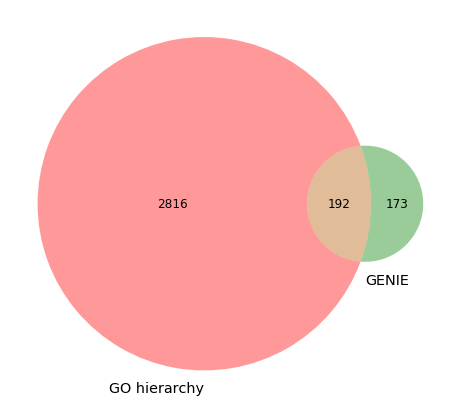

In [9]:
fig = plt.figure(figsize=(8,8))
venn2([genes_orig, genie_genes], ['GO hierarchy', 'GENIE'])
plt.show()
#fig.savefig('../plots/GO_clinical_trial_gene_overlap.png')

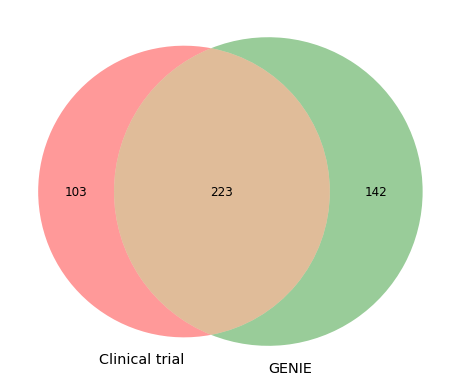

In [8]:
fig = plt.figure(figsize=(8,8))
venn2([genes, genie_genes], ['Clinical trial', 'GENIE'])
plt.show()
#fig.savefig('../plots/GO_clinical_trial_gene_overlap.png')

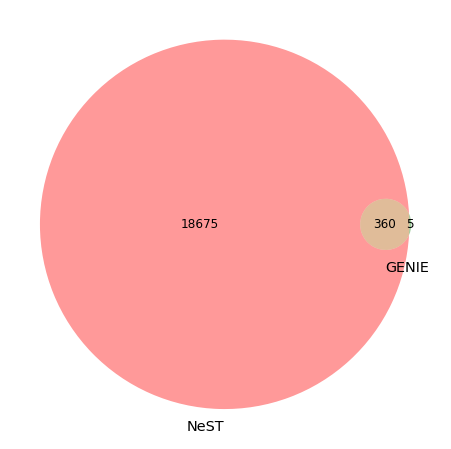

In [10]:
fig = plt.figure(figsize=(8,8))
venn2([set(nest_gene_list), genie_genes], ['NeST', 'GENIE'])
plt.show()
#fig.savefig('../plots/GO_clinical_trial_gene_overlap.png')

In [ ]:
non_overlapping_genes = [g for g in onco_kb_genes if g not in genes_orig]
non_overlapping_genes